# 9주차 수업

### 1. S&P500 구성 종목 뽑기
### 2. 포트폴리오 최적화

**Made by 35기 코딩부장 류제현**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm # 아마 pip install tqdm 이 필요할지도?

In [2]:
# pickle 파일: binary 형태로 직렬화 해서 파일을 저장합니다 -> 읽고 쓰는 속도가 CSV보다 매우 빠름 / CSV처럼 직접 수정은 불가능(무조건 파이썬에서만!)
price = pd.read_pickle("Data/stock_adj.pickle")
con = pd.read_pickle("Data/spx_constitute_daily.pickle")

In [8]:
# 이걸로 매일매일의 S&P500 기업 주식의 수익을 어떻게 뽑아낼 수 있을까요?
con

,permno,start,ending,date
0,87267.0,2011-04-04,2022-12-30,2015-01-02
1,21186.0,1957-03-01,2022-12-30,2015-01-02
2,22517.0,1995-11-27,2022-12-30,2015-01-02
3,91611.0,2009-10-16,2017-03-17,2015-01-02
4,24109.0,1951-09-06,2022-12-30,2015-01-02
...,...,...,...,...
1016079,14939.0,2018-11-06,2022-12-30,2022-12-30
1016080,23026.0,1957-07-10,2022-12-30,2022-12-30
1016081,89393.0,2010-12-20,2022-12-30,2022-12-30
1016082,58819.0,2016-07-01,2022-12-30,2022-12-30


In [11]:
# S&P500에 속하면 1, 아니면 NaN을 기록할 빈 데이터프레임을 하나 생성합니다
spx_mask = pd.DataFrame(index=price.index,
                        columns=price.columns)
spx_mask

PERMNO,10104,10107,10138,10145,10147,10299,10353,10516,10693,10696,...,92988,93002,93089,93096,93132,93159,93246,93422,93429,93436
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
con

,permno,start,ending,date
0,87267.0,2011-04-04,2022-12-30,2015-01-02
1,21186.0,1957-03-01,2022-12-30,2015-01-02
2,22517.0,1995-11-27,2022-12-30,2015-01-02
3,91611.0,2009-10-16,2017-03-17,2015-01-02
4,24109.0,1951-09-06,2022-12-30,2015-01-02
...,...,...,...,...
1016079,14939.0,2018-11-06,2022-12-30,2022-12-30
1016080,23026.0,1957-07-10,2022-12-30,2022-12-30
1016081,89393.0,2010-12-20,2022-12-30,2022-12-30
1016082,58819.0,2016-07-01,2022-12-30,2022-12-30


In [20]:
# 인덱스를 (매일 날짜)를 따라 반복문을 돌립니다

for date in tqdm(spx_mask.index):
    spx_date = con.loc[con.date == date] # 그 날짜에 해당하는 S&P500 구성종목을 가져옵니다
    corp_list = spx_date.permno # 회사 permno를 가져옵니다
    
    # 위에서 만든 빈 데이터 프레임에 채워줍니다
    spx_mask.loc[date, corp_list] = 1

 18%|█▊        | 371/2014 [00:03<00:15, 108.78it/s]


KeyboardInterrupt: 

In [21]:
# 1이 잘 들어갔네요!
spx_mask

PERMNO,10104.0,10107.0,10138.0,10145.0,10147.0,10299.0,10353.0,10516.0,10693.0,10696.0,...,92988.0,93002.0,93089.0,93096.0,93132.0,93159.0,93246.0,93422.0,93429.0,93436.0
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,1,1,1,1,1,1,NaN,1,NaN,1,...,1,1,NaN,1,NaN,1,NaN,1,NaN,NaN
2015-01-05,1,1,1,1,1,1,NaN,1,NaN,1,...,1,1,NaN,1,NaN,1,NaN,1,NaN,NaN
2015-01-06,1,1,1,1,1,1,NaN,1,NaN,1,...,1,1,NaN,1,NaN,1,NaN,1,NaN,NaN
2015-01-07,1,1,1,1,1,1,NaN,1,NaN,1,...,1,1,NaN,1,NaN,1,NaN,1,NaN,NaN
2015-01-08,1,1,1,1,1,1,NaN,1,NaN,1,...,1,1,NaN,1,NaN,1,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,1,1,1,1,NaN,NaN,NaN,1,NaN,1,...,NaN,1,1,1,1,NaN,1,NaN,1,1
2022-12-27,1,1,1,1,NaN,NaN,NaN,1,NaN,1,...,NaN,1,1,1,1,NaN,1,NaN,1,1
2022-12-28,1,1,1,1,NaN,NaN,NaN,1,NaN,1,...,NaN,1,1,1,1,NaN,1,NaN,1,1


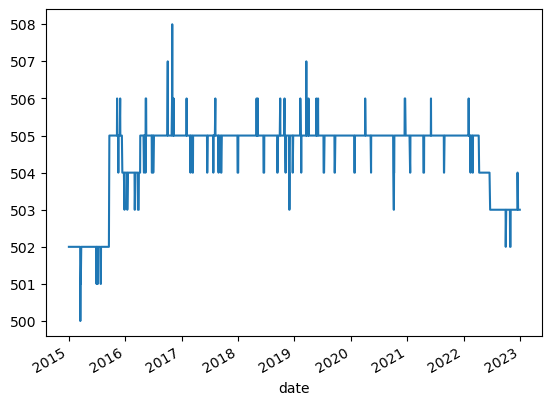

In [24]:
# S&P500 구성종목 개수 합을 한번 살펴볼까요?
spx_mask.sum(1).plot();

In [28]:
# S&P500 기업의 리턴을 어떻게 구하냐... 
## 데이터프레임끼리 착 곱해주면 된다
rtn = price.pct_change(fill_method=None) # fill_method=None (NaN 값이 많은 경우 꼭 넣어줘야함 / Pandas 알고리즘이 좀 이상해서 그렇다)
rtn

PERMNO,10104,10107,10138,10145,10147,10299,10353,10516,10693,10696,...,92988,93002,93089,93096,93132,93159,93246,93422,93429,93436
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.016693,-0.009303,-0.022971,-0.019056,-0.019779,-0.015328,NaN,-0.034602,-0.003221,-0.011328,...,0.001346,-0.015986,-0.012975,-0.006499,-0.008769,-0.065960,-0.008411,-0.056028,0.031881,-0.042041
2015-01-06,-0.010323,-0.014571,-0.017663,-0.002339,-0.019152,-0.027158,NaN,-0.019713,-0.007808,0.001003,...,-0.001176,-0.022743,-0.003484,-0.012656,-0.018676,-0.006742,-0.003915,-0.010599,0.010401,0.005664
2015-01-07,0.000232,0.012705,0.014701,0.007238,0.002441,0.004085,NaN,0.015031,0.030665,0.013593,...,0.005215,0.027013,0.000636,0.012099,0.014357,0.007503,-0.015721,0.008570,0.016954,-0.001562
2015-01-08,0.006025,0.029418,0.011853,0.018219,0.018783,0.027577,NaN,-0.014609,0.023697,0.020327,...,0.003515,0.049975,0.010006,-0.010815,0.027321,0.032270,0.015306,0.051514,-0.010196,-0.001588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.004473,0.002267,0.007617,0.007348,NaN,NaN,NaN,0.012087,0.006108,0.009243,...,NaN,-0.001193,0.006476,0.008227,-0.008545,NaN,0.026729,NaN,0.015451,-0.017551
2022-12-27,0.001608,-0.007414,-0.003510,0.004769,NaN,NaN,NaN,0.013633,-0.003204,0.003584,...,NaN,0.002009,-0.000285,-0.001535,-0.003694,NaN,-0.011281,NaN,0.001506,-0.114089
2022-12-28,-0.008027,-0.010255,-0.023932,-0.012565,NaN,NaN,NaN,-0.023877,-0.005414,-0.009026,...,NaN,-0.015627,-0.007576,-0.008739,-0.014212,NaN,0.055842,NaN,-0.001978,0.033089


In [30]:
# S&P500에 들어간 종목만의 리턴을 계산할 수 있습니다
spx_rtn = spx_mask * rtn
spx_rtn

PERMNO,10104.0,10107.0,10138.0,10145.0,10147.0,10299.0,10353.0,10516.0,10693.0,10696.0,...,92988.0,93002.0,93089.0,93096.0,93132.0,93159.0,93246.0,93422.0,93429.0,93436.0
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.016693,-0.009303,-0.022971,-0.019056,-0.019779,-0.015328,NaN,-0.034602,NaN,-0.011328,...,0.001346,-0.015986,NaN,-0.006499,NaN,-0.06596,NaN,-0.056028,NaN,NaN
2015-01-06,-0.010323,-0.014571,-0.017663,-0.002339,-0.019152,-0.027158,NaN,-0.019713,NaN,0.001003,...,-0.001176,-0.022743,NaN,-0.012656,NaN,-0.006742,NaN,-0.010599,NaN,NaN
2015-01-07,0.000232,0.012705,0.014701,0.007238,0.002441,0.004085,NaN,0.015031,NaN,0.013593,...,0.005215,0.027013,NaN,0.012099,NaN,0.007503,NaN,0.00857,NaN,NaN
2015-01-08,0.006025,0.029418,0.011853,0.018219,0.018783,0.027577,NaN,-0.014609,NaN,0.020327,...,0.003515,0.049975,NaN,-0.010815,NaN,0.03227,NaN,0.051514,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.004473,0.002267,0.007617,0.007348,NaN,NaN,NaN,0.012087,NaN,0.009243,...,NaN,-0.001193,0.006476,0.008227,-0.008545,NaN,0.026729,NaN,0.015451,-0.017551
2022-12-27,0.001608,-0.007414,-0.00351,0.004769,NaN,NaN,NaN,0.013633,NaN,0.003584,...,NaN,0.002009,-0.000285,-0.001535,-0.003694,NaN,-0.011281,NaN,0.001506,-0.114089
2022-12-28,-0.008027,-0.010255,-0.023932,-0.012565,NaN,NaN,NaN,-0.023877,NaN,-0.009026,...,NaN,-0.015627,-0.007576,-0.008739,-0.014212,NaN,0.055842,NaN,-0.001978,0.033089


### 2. 포트폴리오 최적화

In [32]:
# 데이터를 불러옵니다
etf = pd.read_pickle("Data/ETF.pickle")
etf

,VTI,TLT,SHY,GLD,GSG,VNQ
at,,,,,,
2006-07-21,122.25,85.33,79.71,61.71,49.25,66.65
2006-07-24,124.63,85.28,79.71,61.14,49.70,67.75
2006-07-25,125.05,85.03,79.69,61.55,49.25,68.10
2006-07-26,125.39,85.34,79.79,62.00,49.62,68.34
2006-07-27,125.07,85.21,79.83,62.90,50.15,68.12
...,...,...,...,...,...,...
2023-04-25,201.66,106.96,82.35,185.75,20.01,81.25
2023-04-26,200.75,105.82,82.25,184.74,19.60,80.47
2023-04-27,204.52,104.77,82.09,184.75,19.63,82.29


In [37]:
# 리턴을 계산
rtn = etf.pct_change()
rtn

,VTI,TLT,SHY,GLD,GSG,VNQ
at,,,,,,
2006-07-21,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-24,0.019468,-0.000586,0.000000,-0.009237,0.009137,0.016504
2006-07-25,0.003370,-0.002932,-0.000251,0.006706,-0.009054,0.005166
2006-07-26,0.002719,0.003646,0.001255,0.007311,0.007513,0.003524
2006-07-27,-0.002552,-0.001523,0.000501,0.014516,0.010681,-0.003219
...,...,...,...,...,...,...
2023-04-25,-0.016676,0.014704,0.003901,0.005086,-0.018155,-0.009871
2023-04-26,-0.004513,-0.010658,-0.001214,-0.005437,-0.020490,-0.009600
2023-04-27,0.018780,-0.009923,-0.001945,0.000054,0.001531,0.022617


In [38]:
# 어차피 투자 첫날은 수익이 0이기 때문에, dropna보다는 fillna 0을 해주는게 하루 데이터 손실을 줄일 수 있다
rtn = rtn.fillna(0) 
rtn

,VTI,TLT,SHY,GLD,GSG,VNQ
at,,,,,,
2006-07-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006-07-24,0.019468,-0.000586,0.000000,-0.009237,0.009137,0.016504
2006-07-25,0.003370,-0.002932,-0.000251,0.006706,-0.009054,0.005166
2006-07-26,0.002719,0.003646,0.001255,0.007311,0.007513,0.003524
2006-07-27,-0.002552,-0.001523,0.000501,0.014516,0.010681,-0.003219
...,...,...,...,...,...,...
2023-04-25,-0.016676,0.014704,0.003901,0.005086,-0.018155,-0.009871
2023-04-26,-0.004513,-0.010658,-0.001214,-0.005437,-0.020490,-0.009600
2023-04-27,0.018780,-0.009923,-0.001945,0.000054,0.001531,0.022617


In [43]:
# Rabalancing을 수행할 Range를 정의합니다
start_idx = pd.date_range("2007", "2023", freq="BYS") # 맨 뒤는 포함하지 않습니다
end_idx = pd.date_range("2007", "2023", freq="BY") # 맨 뒤는 포함하지 않습니다

start_idx

DatetimeIndex(['2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01',
               '2011-01-03', '2012-01-02', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2017-01-02', '2018-01-01',
               '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-03'],
              dtype='datetime64[ns]', freq='BAS-JAN')

In [44]:
end_idx

DatetimeIndex(['2007-12-31', '2008-12-31', '2009-12-31', '2010-12-31',
               '2011-12-30', '2012-12-31', '2013-12-31', '2014-12-31',
               '2015-12-31', '2016-12-30', '2017-12-29', '2018-12-31',
               '2019-12-31', '2020-12-31', '2021-12-31', '2022-12-30'],
              dtype='datetime64[ns]', freq='BA-DEC')

In [45]:
# 목적함수를 정의합니다
##  샤프 최대화 목적함수를 정의한다 (최소화 알고리즘을 쓸 거기 때문에, 샤프지수에 마이너스를 달아준다)

def obj_sharpe(weights, cov_matrix, mean_rtn):
    portfolio_return = np.dot(weights, mean_rtn)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot((cov_matrix), weights)))
    sharpe_ratio = portfolio_return  / portfolio_volatility
    return -sharpe_ratio

In [46]:
# 최적화 결과를 담을 빈 데이터프레임을 생성
weight_df = pd.DataFrame(columns=rtn.columns) 

In [48]:
# 최적화를 수행할 제약, Bound와 Initial Weights를 셋팅합니다
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(rtn.columns)))
initial_weights = np.ones(len(rtn.columns)) / len(rtn.columns)

In [57]:
for i in tqdm(range(len(start_idx))):
    start = start_idx[i] 
    end = end_idx[i]
    
    rtn_sample = rtn.loc[start:end]
    
    # 공분산 행렬을 추정합니다
    cov_matrix = rtn_sample.cov()
    mean_rtn = rtn_sample.mean()
    
    result = minimize(obj_sharpe,           # 목적함수 
                      initial_weights,        # 초기 Weight
                      args=(cov_matrix,mean_rtn),   # 목적함수에 들어갈 추가적 인수
                      method='SLSQP',            # Solver
                      constraints= constraints, # 제약식 셋팅   
                      bounds=bounds 
                      )
    
    min_variance_weights = result.x  # 알고리즘이 출력한 최적값 저장
    weight_df.loc[end] = min_variance_weights

100%|██████████| 16/16 [00:00<00:00, 40.61it/s]


In [58]:
weight_df

,VTI,TLT,SHY,GLD,GSG,VNQ
2007-12-31,3.160964e-02,0.000000e+00,8.373478e-01,8.445822e-02,4.658435e-02,3.993930e-17
2008-12-31,3.070764e-14,5.295066e-01,3.919752e-01,4.224805e-02,3.285589e-14,3.627021e-02
2009-12-31,3.970045e-01,0.000000e+00,2.029626e-16,6.029955e-01,1.084202e-17,0.000000e+00
2010-12-31,2.324822e-02,3.580824e-16,8.918912e-01,5.920406e-02,2.572813e-16,2.565655e-02
2011-12-30,2.646655e-01,4.968934e-01,1.331242e-01,7.013975e-02,0.000000e+00,3.517720e-02
2012-12-31,4.695330e-01,3.659134e-01,0.000000e+00,2.330388e-02,9.454243e-17,1.412497e-01
2013-12-31,8.187413e-01,6.245005e-17,1.812587e-01,0.000000e+00,1.249001e-16,1.665335e-16
2014-12-31,2.036123e-01,5.025438e-01,0.000000e+00,1.817394e-17,0.000000e+00,2.938440e-01
2015-12-31,1.387779e-15,2.151057e-16,1.122305e-01,0.000000e+00,0.000000e+00,8.877695e-01
2016-12-30,4.842897e-01,0.000000e+00,1.632690e-01,3.382408e-01,1.420052e-02,0.000000e+00


In [59]:
def simulate_strategy(group_weight_df:pd.DataFrame, daily_rtn_df:pd.DataFrame, fee_rate:float):
        '''
        전략의 수익을 평가합니다(Long-Only Portfolio)
        '''
        pf_value = 1
        pf_dict = {}

        weight = group_weight_df.iloc[0] # 시작 weight를 지정해준다 (첫 weight에서 투자 시작, 장마감 직전에 포트폴리오 구성)
        dollar_value = weight * pf_value # Start Dollar Value를 지정
        
        rebalancing_idx = group_weight_df.index # 리벨런싱 할 날들
        start_idx = rebalancing_idx[0]          # 투자 시작일
        
        idx = daily_rtn_df.loc[start_idx:].index
        weight_df = pd.DataFrame(index=idx, columns=daily_rtn_df.columns) # Weight 변화를 기록할 빈 데이터프레임 생성
        weight_df.loc[start_idx] = weight # 시작 weight를 기록

        for idx, row in daily_rtn_df.loc[start_idx:].iloc[1:].iterrows(): # Daily로 반복 / 시작 weight 구성 다음 날부터 성과를 평가
            # 수익률 평가가 리밸런싱보다 선행해야함
            dollar_value = dollar_value * (1+np.nan_to_num(row)) # update the dollar value
            pf_value = np.nansum(dollar_value) # update the pf value
            
            weight = dollar_value / pf_value # update the weight

            if idx in rebalancing_idx: # Rebalancing Date (장마감 직전에 리벨런싱 실시)
                weight = group_weight_df.loc[idx] # Weight Rebalancing
                target_dollar_value = np.nan_to_num(pf_value * weight) * (1 - fee_rate)
                dollar_fee = np.nansum(np.abs(target_dollar_value - np.nan_to_num(dollar_value)) * fee_rate) # fee계산
                pf_value = pf_value - dollar_fee # fee 차감

                dollar_value = weight * pf_value  # dollar value를 Rebalancing 이후로 update
            
            weight_df.loc[idx] = weight # weight 변화를 기록
            pf_dict[idx] = pf_value

        return pf_dict

In [60]:
result = simulate_strategy(weight_df, rtn, fee_rate=0)

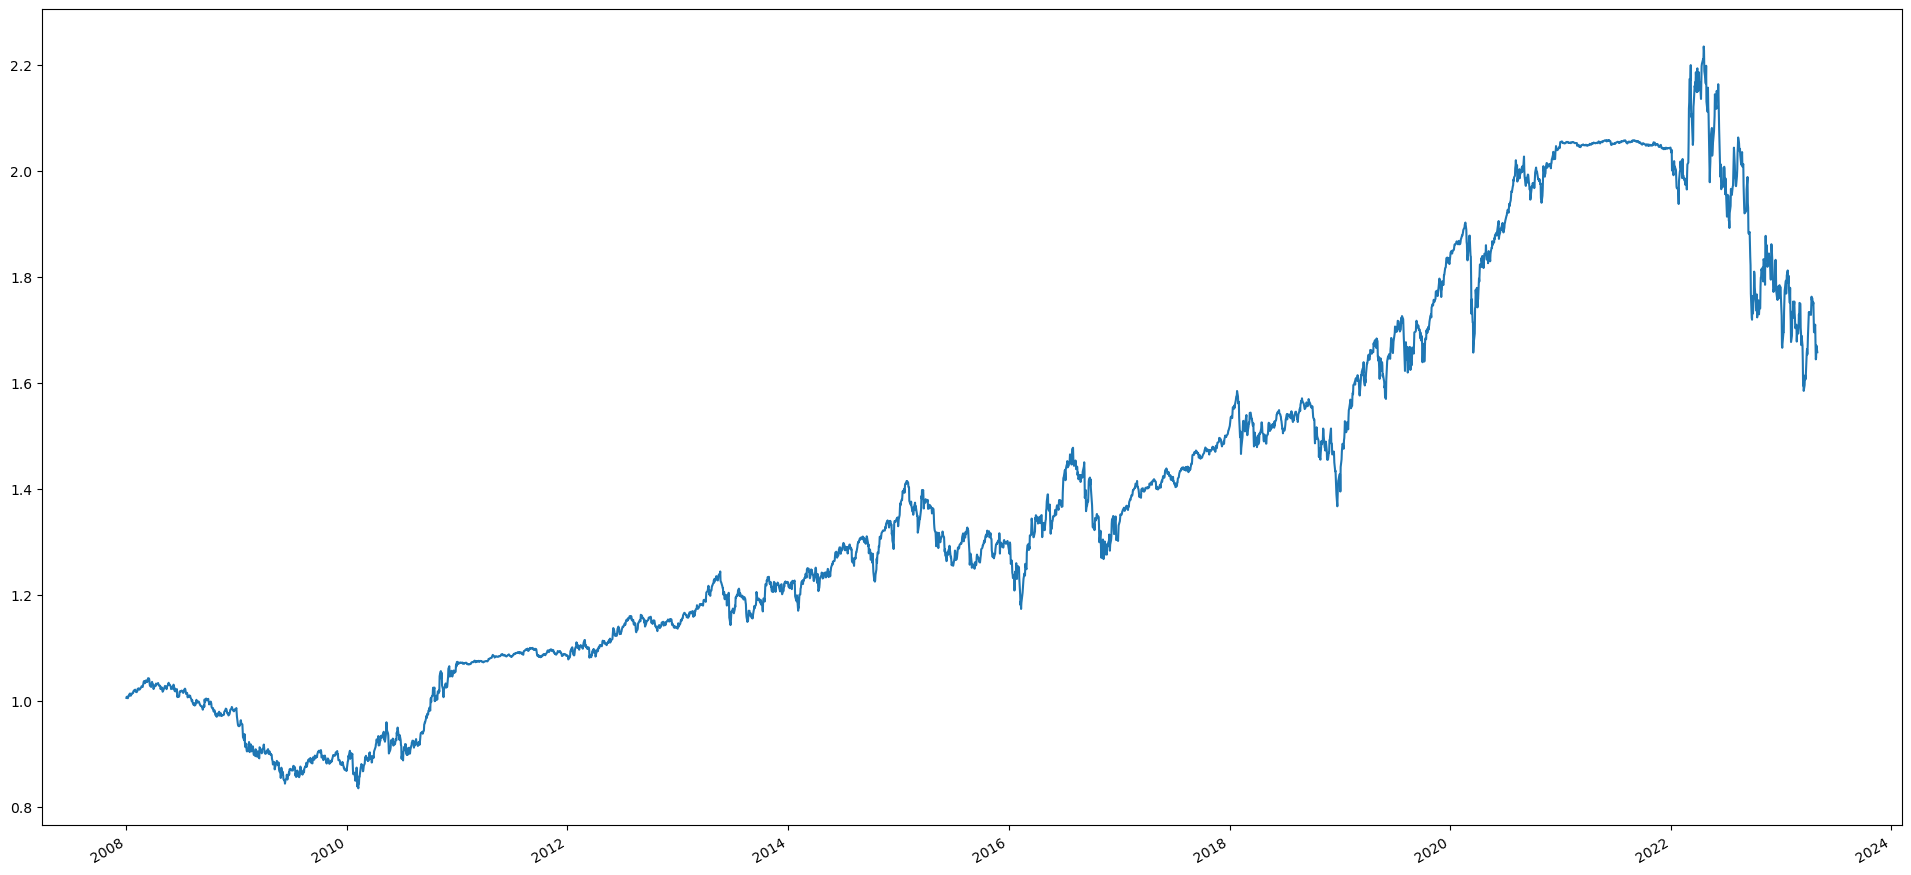

In [61]:
pd.Series(result).plot(figsize=(24,12));

    한 학기 고생 많으셨습니다!